<a href="https://colab.research.google.com/github/gitmnk/ml/blob/master/Hands_OnMachineLearningWithScikit_Chapter03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

(70000, 784)
(70000,)


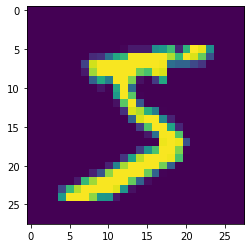

5


In [4]:
X, y = mnist["data"], mnist["target"]
# X is (70k, 784), essentially each pixel is a feature. So we have 784 (column) pixels (features) per image (70k) 
print(X.shape)
# y is the output prediction (what number is it) per input.
print(y.shape)

import matplotlib as mpl
import matplotlib.pyplot as plt
# Convert to numpy for correct arraylike index.
# https://stackoverflow.com/questions/65506131/why-does-using-x0-in-mnist-classifier-code-give-me-an-error
some_digit = X.to_numpy()[0]

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image)
plt.show()
print(y[0])

In [5]:
# Cast y as integewr and not string. 
import numpy as np
y = y.astype(np.uint8)

# MNIST set is already broken inot Train and test.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# Lets just train the classifier only for digit 5.
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
# Use Stochastic Gradient Descent (SGD)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
print(sgd_clf.predict([some_digit]))
# Implementing Cross Validation 
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.to_numpy()[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train.to_numpy()[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


[ True]
0.95035
0.96035
0.9604


In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd_clf, X_train, 
                         y_train_5, scoring="accuracy",
                         cv=3)
print(scores)

[0.95035 0.96035 0.9604 ]


In [10]:
#The 95% accuracy is because, only about 10% images are '5'. So
# if you guessed that it's not a 5 everytime, you still get 90% right.
# This tells why calssification may not the best measured with accuracy.
# So lets use confusion matrix,  
# The general idea is to count the number of times instances of class A are
# classified as class B. For example, to know the number of times the classifier confused
# images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
# matrix.

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [11]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_5, y_train_pred))

# Ideally if all 5s were correclty predicted and all non-5s were correctly predicted:
y_train_perfect_predictions = y_train_5
print(confusion_matrix(y_train_5, y_train_perfect_predictions))\
#              Negative  Positive
#  Non 5s     [[54579       0]
#  5s         [    0    5421]]
#
# Precison = TP/TP+FP , Recall = TP/TP+FN

from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

[[53892   687]
 [ 1891  3530]]
[[54579     0]
 [    0  5421]]
0.8370879772350012
0.6511713705958311


In [12]:
# F1 Score is harmonic mean of percision and recall. 
# Property of harmonic mean is that it gives much more weight to low values.
# So, the classifer will only get a high F1 score if both recall and precision
# are high.
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


In [13]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
# Lets give the option to cross_val_predict to return decision score instead of predictions.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# Now plot the decision scores.
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

[2164.22030239]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


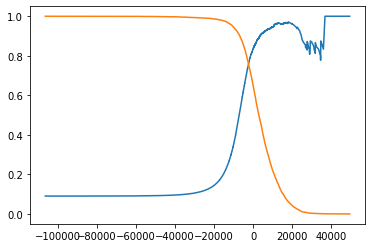

In [14]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "", label="Precision")
  plt.plot(thresholds, recalls[:-1], "", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

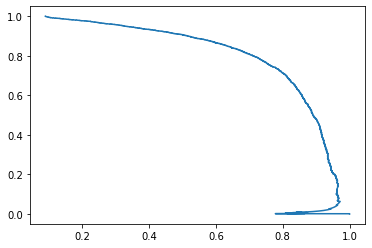

In [15]:
# Print precision / recall curve
plt.plot(precisions, recalls, "", label=None)
plt.show()

# Ideally a curve closer to top-right corner is nice!

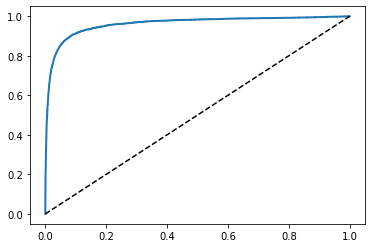

0.9604938554008616

In [16]:
# Alternatively there is ROC curve (Reciever Operating Characterstic). 
# Plots True positive rate (Recall) vs False positive rate. 
# False positive rate(FPR) = 1 - true negative rate. 
# TNR (Specificity) = TN/(TN+FP), FPR = FP/(TN+FP). 
# ROC is a curve between Recall and 1 - Specificity.

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, labels=None):
  plt.plot(fpr, tpr, linewidth=2, label="None")
  plt.plot([0,1], [0,1], 'k--') # dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()

# Area Under curve of ROC is 0.5 for purely random classifer.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

In [17]:
# Between the two PR and AUC curve, RULE OF THUMB:
# Use PR when you the positive rate class is rare. 
# Like here from AUC it seem the model is quite good, 
# But PR curve shows there is room for improvement.

In [18]:
# Lets find PR curve and AOC for RandomForestClassifer
# RF classifer does not have a decision_function. Instead has a predict_proba.
# Array containing a row per instance and a column per class. E.g. 70% chance that
# image represents a 5.
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")
# ROC works on scores, not probability.
y_scores_forest = y_probas_forest[:,1]  # probability of positive class, which is at 1st index of this 2 column array.
print(y_probas_forest)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]


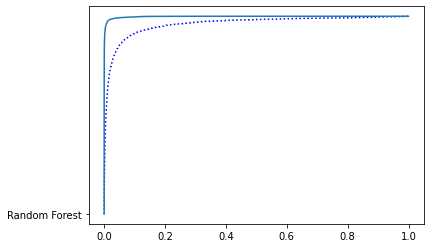

In [19]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, "", "Random Forest")
plt.show()

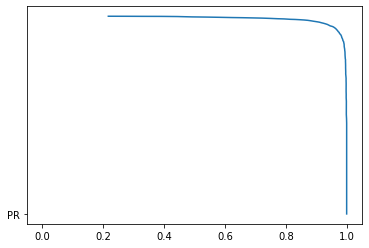

In [20]:
# Lets plot the PR curve as well. 
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)
plt.plot(precisions, recalls, "", "PR")
# Looks much better than SGD curve. 99% precision and 86.6 recall.

In [21]:
# Scikit automatically detecs if we are trying to use binary classification for a multi
# classification problem, and converts to OvA (One vs All), basically binary classifer for
# each digit in this example.
sgd_clf.fit(X_train, y_train) # not y_train_5

SGDClassifier(random_state=42)

In [22]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
3


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [23]:
# Lets use RF classifier
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))

[5]
[[0.   0.   0.01 0.08 0.   0.9  0.   0.   0.   0.01]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [24]:
# ERROR ANALYSIS
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
confusion_matrix = confusion_matrix(y_train, y_train_pred) 
confusion_matrix

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

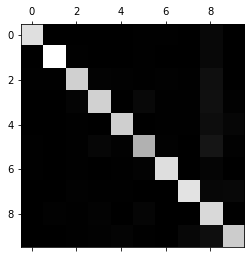

In [25]:
plt.matshow(confusion_matrix, cmap=plt.cm.gray)
plt.show()

     pixel1  pixel2  pixel3  pixel4  ...  pixel781  pixel782  pixel783  pixel784
7       0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
10      0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
12      0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
27      0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
30      0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
44      0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
49      0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
50      0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
74      0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
86      0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
98      0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0
107     0.0     0.0     0.0 

AttributeError: ignored

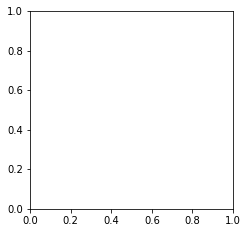

In [26]:
# SGDClassifer is a linear model. So it assigns weight per class to each pixel. 
# When it sees a new image, it just sums up the weighted piexel intensities to get 
# a score for each class. So since 3s and 5s differ only by a few pixels, the model
# confuses them.

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    i = 0
    print(instances)
    for instance in instances:
      if (i == 0):
         i+=1
         continue
      print(instance)
      break
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

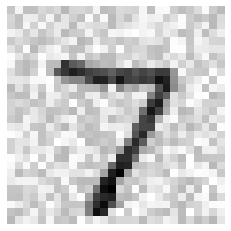

In [37]:
# noise shape is 60k x 784
noise = np.random.randint(0,  100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
# Target images are original images.
y_train_mod = X_train 
y_test_mod = X_test

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

plot_digit(X_test_mod.to_numpy()[0])


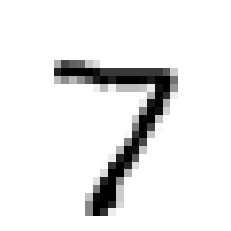

In [36]:
plot_digit(X_test.to_numpy()[0])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


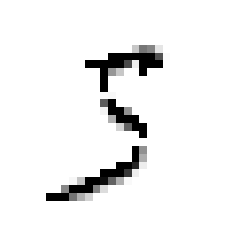

In [41]:
# Train a classifier that cleans the noisy input image.
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mod.to_numpy()[0]])
plot_digit(clean_digit)